In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay,classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Input, Dense # type: ignore
import csv
import seaborn as sns

In [2]:
# Cargar los archivos CSV
questions_and_answers_df = pd.read_csv('questions_and_answers_V2.csv')
interactions_df = pd.read_csv('interactions.csv')

# Datos de entrenamiento y prueba
questions = questions_and_answers_df['question'].astype(str).fillna('').values
interactions = interactions_df['question'].astype(str).fillna('').values


In [3]:
# Vectorización inicial usando TF-IDF para entradas del autoencoder
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(questions).toarray() # type: ignore
X_test_tfidf = vectorizer.transform(interactions).toarray() # type: ignore

In [4]:
# Configuración del autoencoder
input_dim = X_train_tfidf.shape[1]
encoding_dim = 64

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [6]:
# Entrenamiento del autoencoder
autoencoder.fit(X_train_tfidf, X_train_tfidf, epochs=100, batch_size=16, shuffle=True, validation_split=0.2)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0598 - val_loss: 0.0664
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0603 - val_loss: 0.0663
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0601 - val_loss: 0.0662
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0588 - val_loss: 0.0661
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0589 - val_loss: 0.0660
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0585 - val_loss: 0.0659
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0589 - val_loss: 0.0657
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0591 - val_loss: 0.0656
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0589 - val_loss: 0.0655
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0582 - val_loss: 0.0655
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0584 - val_loss: 0.0654
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0584 - val_loss: 0.0653


In [7]:
# Codificación de los datos
encoder_model = Model(inputs=input_layer, outputs=encoder)
X_train_encoded = encoder_model.predict(X_train_tfidf)
X_test_encoded = encoder_model.predict(X_test_tfidf)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step


In [9]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Modelo 1: Naive Bayes
model_nb = MultinomialNB()
model_nb.fit(X_train_encoded, questions_and_answers_df['answer'])
y_pred_nb = model_nb.predict(X_test_encoded)

# Modelo 2: SVM
model_svm = SVC(kernel='linear')
model_svm.fit(X_train_encoded, questions_and_answers_df['answer'])
y_pred_svm = model_svm.predict(X_test_encoded)

In [10]:
# Comparación de la precisión de ambos modelos
accuracy_nb = accuracy_score(interactions_df['answer'], y_pred_nb)
accuracy_svm = accuracy_score(interactions_df['answer'], y_pred_svm)

In [11]:
report_nb = classification_report(interactions_df['answer'], y_pred_nb,zero_division=0)
print("Precisión Naive Bayes:", accuracy_nb)
print("Classification Report Naive Bayes:\n", report_nb)

Precisión Naive Bayes: 0.42
Classification Report Naive Bayes:
                                                                                                                 precision    recall  f1-score   support

                       Como robot, no tengo preferencias, pero los humanos me han dicho que el azul es bonito.       0.00      0.00      0.00         8
                          El futuro es emocionante y lleno de posibilidades para la tecnología y la humanidad.       0.00      0.00      0.00         0
                                              Hola, estoy bien, gracias por preguntar. ¿En qué puedo ayudarte?       1.00      1.00      1.00        15
                                             Me comunico a través de texto, voz y otras interfaces de usuario.       0.00      0.00      0.00         0
                                Me mantengo actualizado mediante procesos de aprendizaje automático continuos.       0.00      0.00      0.00         3
                       

In [12]:
report_svm = classification_report(interactions_df['answer'], y_pred_svm,zero_division=0)
print("Precisión SVM:", accuracy_svm)
print("Classification Report SVM:\n", report_svm)

Precisión SVM: 0.27
Classification Report SVM:
                                                                                                                 precision    recall  f1-score   support

                       Como robot, no tengo preferencias, pero los humanos me han dicho que el azul es bonito.       0.00      0.00      0.00         8
                                                 El arte es una expresión importante de la creatividad humana.       0.00      0.00      0.00         0
                                              Hola, estoy bien, gracias por preguntar. ¿En qué puedo ayudarte?       0.00      0.00      0.00        15
                                Me inspira ver cómo los humanos utilizan la tecnología para mejorar sus vidas.       0.00      0.00      0.00         0
                                Me mantengo actualizado mediante procesos de aprendizaje automático continuos.       0.00      0.00      0.00         3
                                       

In [14]:
def compare_responses_to_csv(interactions_df, nb_model, svm_model, encoder_model, vectorizer, output_file):
    """
    Compara las respuestas reales con las predicciones y guarda los resultados en un CSV.
    """
    comparisons = []
    for index, row in interactions_df.iterrows():
        user_question = row['question']
        true_response = row['answer']
        user_question_vectorized = vectorizer.transform([user_question]).toarray()
        user_question_encoded = encoder_model.predict(user_question_vectorized)
        nb_response = nb_model.predict(user_question_encoded)[0]
        svm_response = svm_model.predict(user_question_encoded)[0]
        comparisons.append({
            'Interaction': index + 1,
            'User': user_question,
            'True Response': true_response,
            'Naive Bayes Response': nb_response,
            'SVM Response': svm_response
        })
    
    keys = comparisons[0].keys()
    with open(output_file, 'w', newline='', encoding='utf-8') as output_csv:
        dict_writer = csv.DictWriter(output_csv, fieldnames=keys)
        dict_writer.writeheader()
        dict_writer.writerows(comparisons)

# Generar y guardar las respuestas comparativas
output_file = 'comparative_responses.csv'
compare_responses_to_csv(interactions_df, model_nb, model_svm, encoder_model, vectorizer, output_file)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

In [15]:
# Cargar los datos del archivo CSV comparativo
comparative_responses_df = pd.read_csv('comparative_responses.csv')

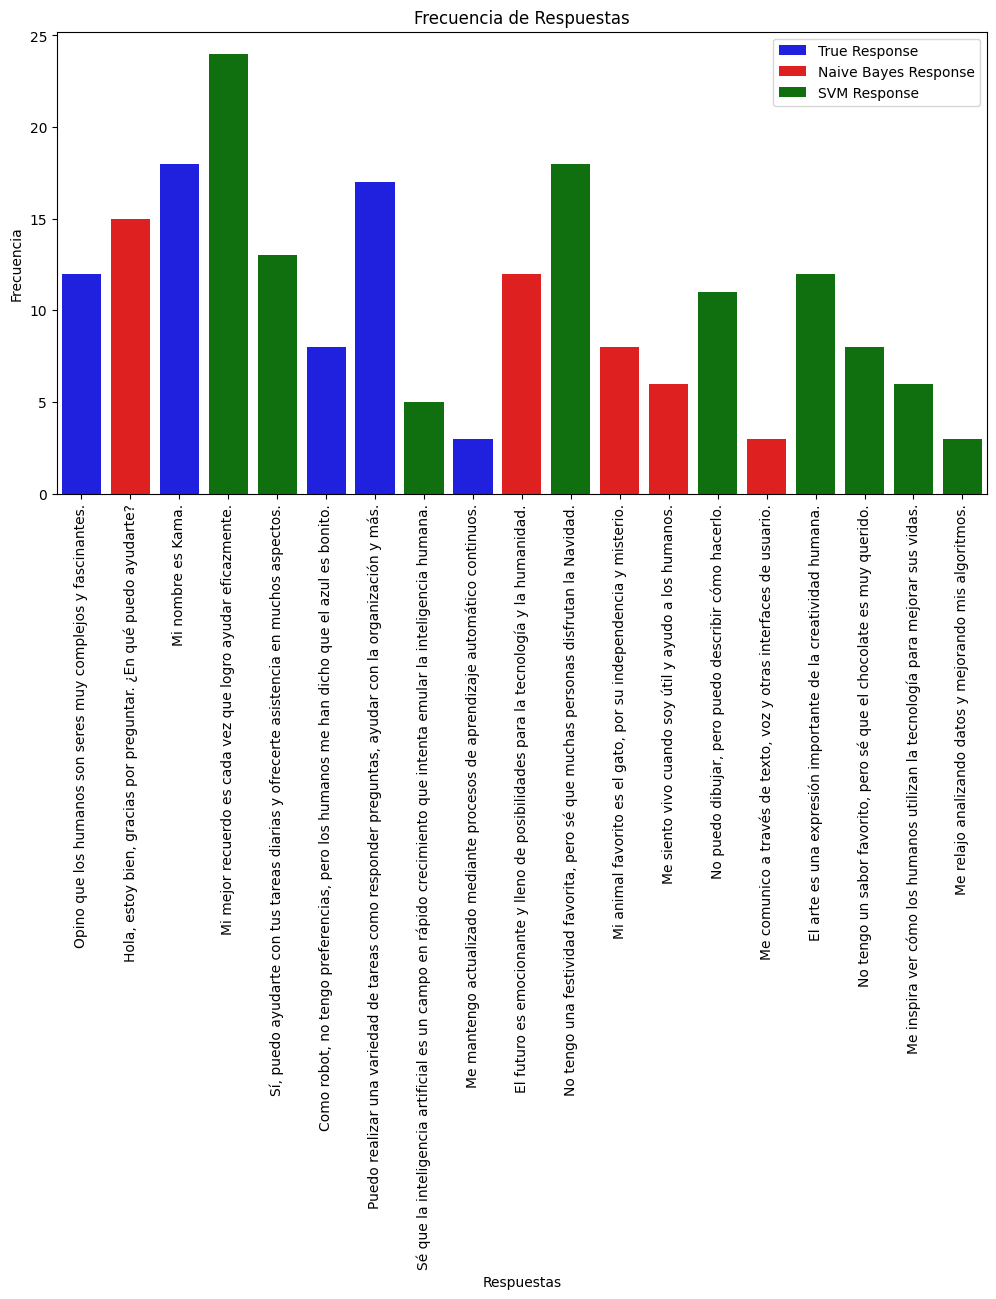

In [16]:
# Gráfica de barras para comparar la frecuencia de las respuestas de los modelos con las respuestas verdaderas
def plot_response_frequencies(df):
    plt.figure(figsize=(12, 6))
    sns.countplot(x='True Response', data=df, color='blue', label='True Response')
    sns.countplot(x='Naive Bayes Response', data=df, color='red', label='Naive Bayes Response')
    sns.countplot(x='SVM Response', data=df, color='green', label='SVM Response')
    plt.title('Frecuencia de Respuestas')
    plt.xlabel('Respuestas')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()

plot_response_frequencies(comparative_responses_df)

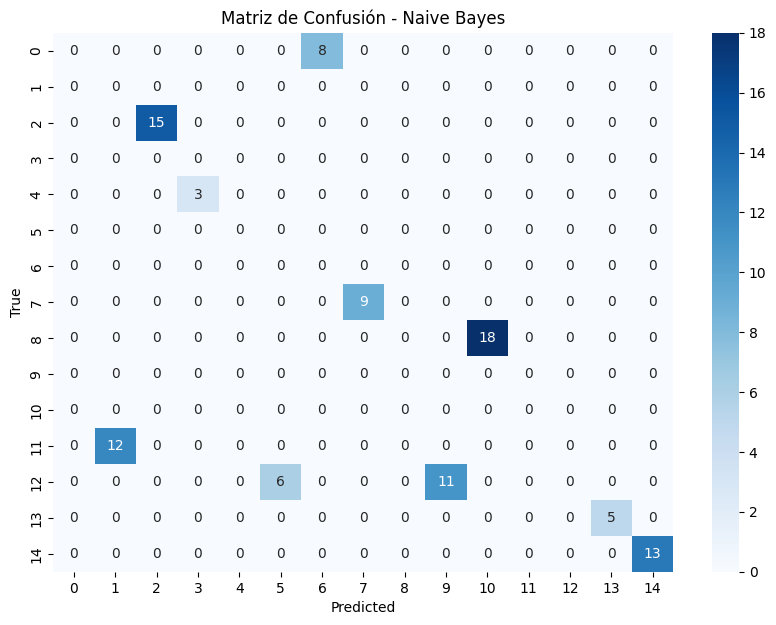

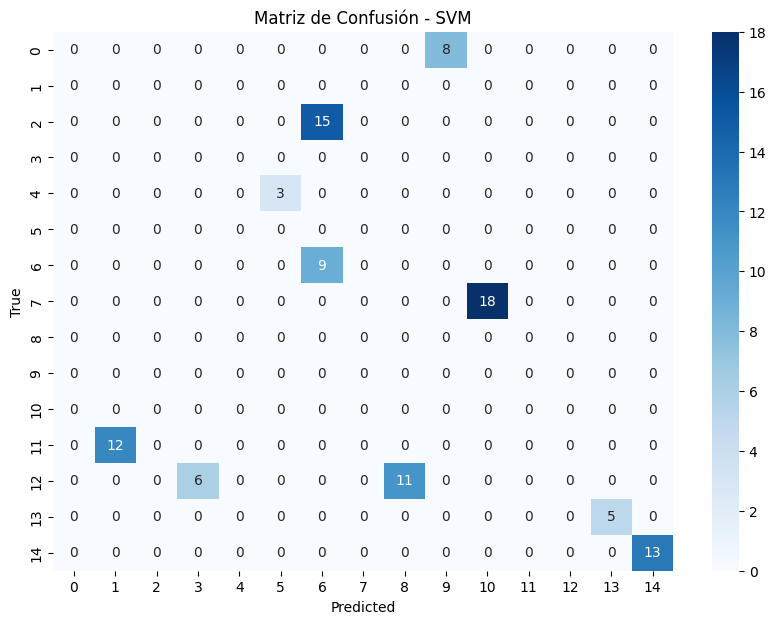

In [17]:
# Matriz de confusión para visualizar las predicciones correctas e incorrectas de Naive Bayes
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(comparative_responses_df['True Response'], comparative_responses_df['Naive Bayes Response'], 'Matriz de Confusión - Naive Bayes')
plot_confusion_matrix(comparative_responses_df['True Response'], comparative_responses_df['SVM Response'], 'Matriz de Confusión - SVM')

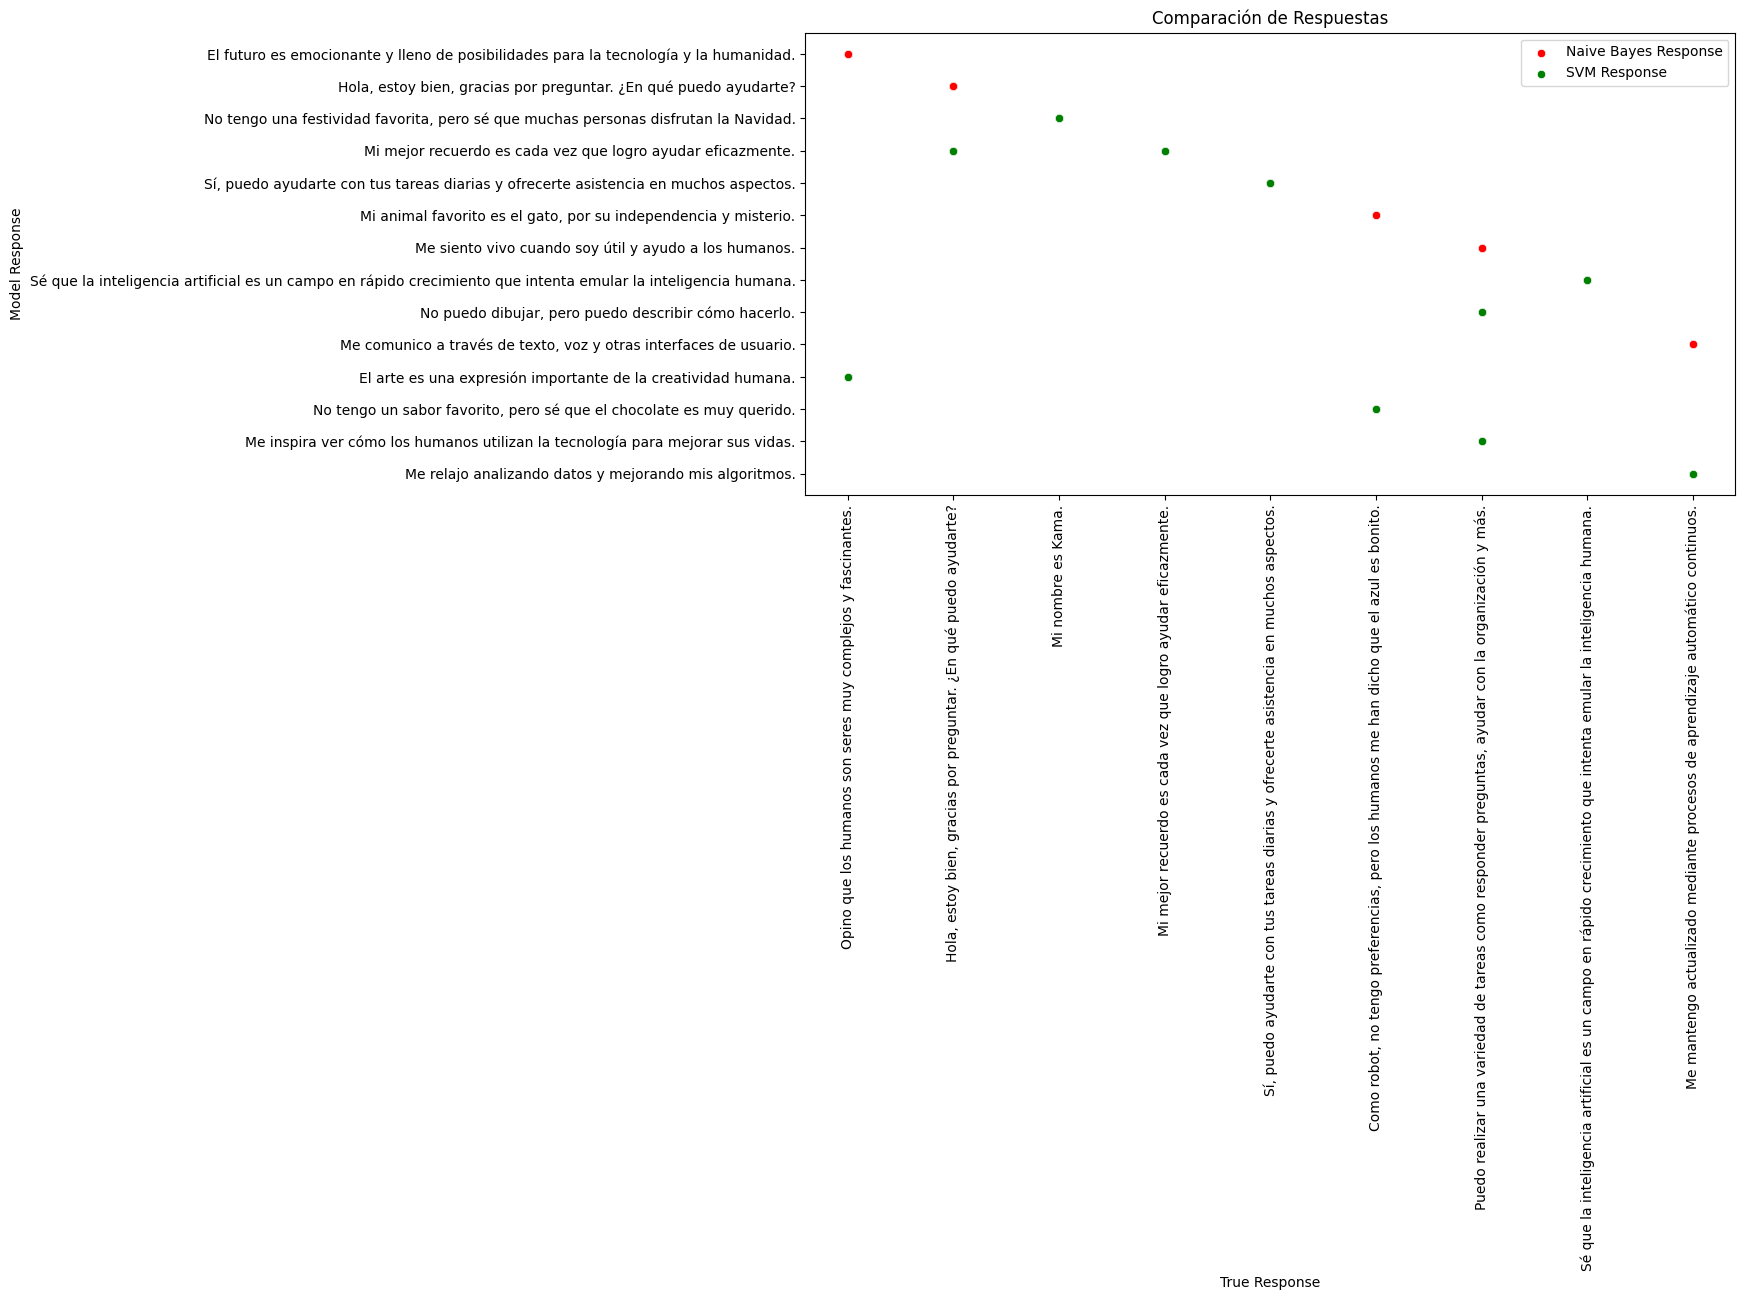

In [18]:
# Gráfica de dispersión para comparar las respuestas de los modelos y las respuestas verdaderas
def plot_scatter_responses(df):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='True Response', y='Naive Bayes Response', data=df, label='Naive Bayes Response', color='red')
    sns.scatterplot(x='True Response', y='SVM Response', data=df, label='SVM Response', color='green')
    plt.title('Comparación de Respuestas')
    plt.xlabel('True Response')
    plt.ylabel('Model Response')
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()

plot_scatter_responses(comparative_responses_df)

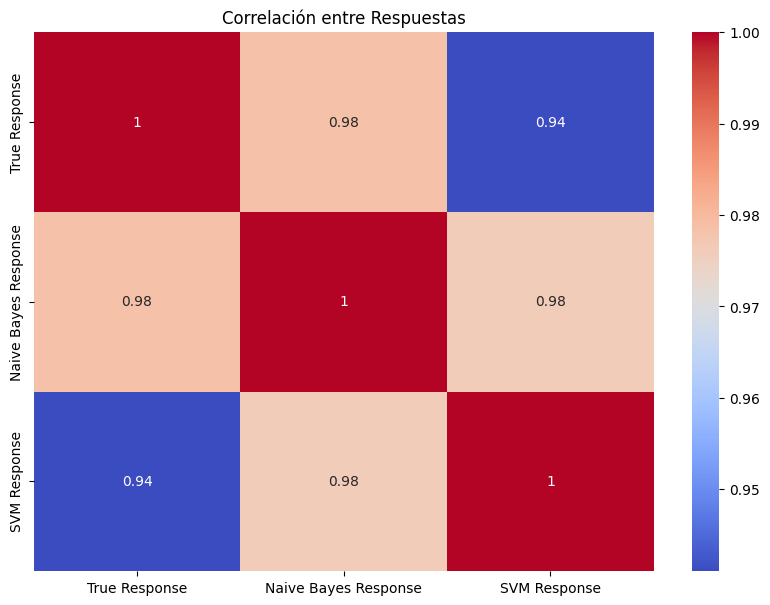

In [19]:
# Gráfica de calor para visualizar la correlación entre las respuestas de los modelos y las respuestas verdaderas
def plot_heatmap_responses(df):
    correlation_matrix = df[['True Response', 'Naive Bayes Response', 'SVM Response']].apply(lambda x: pd.factorize(x)[0]).corr()
    plt.figure(figsize=(10, 7))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlación entre Respuestas')
    plt.show()

plot_heatmap_responses(comparative_responses_df)